# Example: Solving a Task Without RL

Let's consider a simple task: balancing a pole on a cart (the classic CartPole problem).

**Without RL:**
- We use a fixed, hand-crafted policy (e.g., always move the cart in the direction the pole is falling).
- This approach does not learn from experience and cannot adapt to new situations.

*This policy is simple but not optimal. It cannot improve with experience. Later, we'll compare this to a learned RL policy!*

In [2]:
import gymnasium as gym
import numpy as np

# Uninstall gym and install gymnasium
!pip uninstall -y gym
!pip install -qqq gymnasium

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2
Hand-crafted policy survived for 45 steps.


In [19]:
# Visualization for Hand-Crafted Policy (No RL)
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def run_handcrafted_policy(render=True):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    state, info = env.reset() # Update to gymnasium API
    frames = []
    done = False
    steps = 0 # Re-initialize steps variable
    while not done:
        if render:
            frames.append(env.render())
        action = 1 if state[2] > 0 else 0
        state, reward, terminated, truncated, info = env.step(action) # Update to gymnasium API
        done = terminated or truncated # Combine terminated and truncated for done
        steps += 1 # Increment steps
    env.close()
    print(f'Pole fell after {steps} steps (hand-crafted policy).')
    return frames

def display_frames_as_gif(frames):
    fig = plt.figure(figsize=(frames[0].shape[1]/72, frames[0].shape[0]/72))
    plt.axis('off')
    ims = [[plt.imshow(frame, animated=True)] for frame in frames]
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    plt.close(fig)
    return HTML(ani.to_jshtml())

frames = run_handcrafted_policy()
display_frames_as_gif(frames)

Pole fell after 31 steps (hand-crafted policy).


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Group Relative Policy Optimization (GRPO): Theory and Exercises

This Colab-ready notebook covers the theory and practical exercises for Group Relative Policy Optimization (GRPO), based on the DeepSeek R1 and related RL resources. You will learn the motivation, theory, and implementation of GRPO, and get hands-on experience with code exercises.

---

**Outline:**
1. Import Required Libraries
2. Theory: GRPO Overview
3. Theory: Policy Gradient Methods
4. Theory: The GRPO Algorithm
5. Exercise: Implementing the GRPO Update Rule
6. Exercise: Policy Network Architecture
7. Exercise: Training Loop for GRPO
8. Exercise: Visualizing Training Progress
9. Exercise: Hyperparameter Tuning

---

*Let's get started!*

In [3]:
# 1. Import Required Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from typing import List

# If running in Colab, install extra packages if needed
try:
    import datasets
    import trl
except ImportError:
    !pip install -qqq datasets==3.2.0 transformers==4.47.1 trl==0.14.0 peft==0.14.0 accelerate==1.2.1 bitsandbytes==0.45.2 wandb==0.19.7 --progress-bar off
    import datasets
    import trl


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.9.0 which is incompatible.


# 2. Theory: GRPO Overview

Group Relative Policy Optimization (GRPO) is a reinforcement learning algorithm designed to efficiently align large language models (LLMs) with human preferences or verifiable objectives. GRPO is especially useful for tasks where multiple candidate responses can be generated and compared within a group.

**Key ideas:**
- Instead of comparing just two responses (as in PPO or DPO), GRPO generates a group of responses for each prompt and evaluates them together.
- Rewards can come from any function: a reward model, rule-based checks, or even human feedback.
- GRPO normalizes rewards within each group, making learning more stable and robust.
- The algorithm updates the policy to favor responses that are better than the group average, while penalizing those that are worse.

**Why GRPO?**
- More stable and efficient than pairwise methods.
- Flexible: works with any reward function.
- Used in state-of-the-art LLMs like DeepSeek R1 for reasoning and alignment.

*Next, let's review the basics of policy gradient methods that GRPO builds upon.*

# 3. Theory: Policy Gradient Methods

Policy gradient methods are a family of reinforcement learning algorithms that directly optimize the parameters of a policy (the agent's decision-making function) to maximize expected reward.

**REINFORCE Algorithm:**
- The classic policy gradient method.
- The agent samples actions according to its policy, collects rewards, and updates the policy to increase the probability of actions that led to higher rewards.

**Mathematical Formulation:**

The policy gradient objective is:

$$
J(\theta) = \mathbb{E}_{\pi_\theta}[R]
$$

The gradient is:

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} [\nabla_\theta \log \pi_\theta(a|s) \cdot (R - b)]
$$

Where:
- $\pi_\theta(a|s)$: Policy probability of action $a$ in state $s$
- $R$: Reward
- $b$: Baseline (e.g., average reward) to reduce variance

*GRPO generalizes this idea by comparing multiple actions (responses) within a group, rather than just one at a time.*

# 4. Theory: The GRPO Algorithm

GRPO extends policy gradient methods by evaluating and optimizing over groups of responses.

**Algorithm Steps:**
1. For each prompt, generate a group of $G$ responses.
2. Compute a reward for each response using a reward function (can be rule-based, model-based, or human feedback).
3. Normalize rewards within the group:

$$
A_i = \frac{r_i - \text{mean}(\{r_1, ..., r_G\})}{\text{std}(\{r_1, ..., r_G\})}
$$

where $A_i$ is the advantage for response $i$.
4. Update the policy to increase the probability of responses with $A_i > 0$ and decrease for $A_i < 0$.
5. Use a clipped objective and KL penalty for stability:

$$
J_{GRPO}(\theta) = \mathbb{E}\left[\min\left(ratio \cdot A, \text{clip}(ratio, 1-\epsilon, 1+\epsilon) \cdot A\right) - \beta D_{KL}(\pi_\theta || \pi_{ref})\right]
$$

- $ratio = \frac{\pi_\theta(o_i|q)}{\pi_{\theta_{old}}(o_i|q)}$
- $\epsilon$: Clipping parameter
- $\beta$: KL penalty coefficient

**Summary:**
- GRPO is more stable than pairwise methods (like PPO/DPO)
- Works with any reward function
- Used for aligning LLMs with human preferences or verifiable objectives

*Next, let's implement the GRPO update rule!*

In [4]:
# 5. Exercise: Implementing the GRPO Update Rule

# Given: rewards (list of floats), old_log_probs (tensor), new_log_probs (tensor), epsilon (float), beta (float), kl_div (tensor)
# TODO: Complete the GRPO update rule below

def grpo_advantages(rewards: List[float]):
    rewards = np.array(rewards)
    mean = rewards.mean()
    std = rewards.std() + 1e-8
    return (rewards - mean) / std

# Example usage:
rewards = [1, 0, 0, 1]  # 2 correct, 2 incorrect
advantages = grpo_advantages(rewards)
print('Advantages:', advantages)

# Now, fill in the GRPO loss calculation (PyTorch)
def grpo_loss(new_log_probs, old_log_probs, advantages, epsilon=0.2, beta=0.04, kl_div=None):
    # new_log_probs, old_log_probs: shape (batch,)
    # advantages: shape (batch,)
    prob_ratio = torch.exp(new_log_probs - old_log_probs)
    clipped_ratio = torch.clamp(prob_ratio, 1 - epsilon, 1 + epsilon)
    loss1 = -prob_ratio * advantages
    loss2 = -clipped_ratio * advantages
    policy_loss = torch.max(loss1, loss2).mean()
    kl_penalty = beta * kl_div.mean() if kl_div is not None else 0.0
    return policy_loss + kl_penalty

# EXERCISE: Try changing the rewards and see how the advantages and loss change!

Advantages: [ 0.99999998 -0.99999998 -0.99999998  0.99999998]


In [5]:
# 6. Exercise: Policy Network Architecture

# Here is a simple policy network for discrete action spaces (e.g., CartPole, simple RL tasks)
# EXERCISE: Try changing the hidden layer size or adding more layers!

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
    def forward(self, x):
        return self.net(x)

# Example usage:
# state_dim = 4  # e.g., for CartPole
# action_dim = 2
# policy = PolicyNetwork(state_dim, action_dim)
# print(policy)

# EXERCISE: Try different architectures and see how it affects learning!

In [ ]:
# Improved Training Loop for GRPO
# - More episodes
# - Larger hidden layer
# - Lower learning rate
# - Policy update after every group

import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
    def forward(self, x):
        return self.net(x)

def grpo_advantages(rewards):
    rewards = np.array(rewards)
    mean = rewards.mean()
    std = rewards.std() + 1e-8
    return (rewards - mean) / std

def grpo_loss(new_log_probs, old_log_probs, advantages, epsilon=0.2, beta=0.04, kl_div=None):
    prob_ratio = torch.exp(new_log_probs - old_log_probs)
    clipped_ratio = torch.clamp(prob_ratio, 1 - epsilon, 1 + epsilon)
    loss1 = -prob_ratio * advantages
    loss2 = -clipped_ratio * advantages
    policy_loss = torch.max(loss1, loss2).mean()
    kl_penalty = beta * kl_div.mean() if kl_div is not None else 0.0
    return policy_loss + kl_penalty

# --- Training ---
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy = PolicyNetwork(state_dim, action_dim, hidden_dim=128)
optimizer = optim.Adam(policy.parameters(), lr=5e-3)

group_size = 8
num_episodes = 800
all_rewards = []

for episode in range(num_episodes):
    states, actions, rewards, log_probs = [], [], [], []
    state = env.reset()
    done = False
    ep_reward = 0
    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        logits = policy(state_tensor)
        action_dist = torch.distributions.Categorical(logits=logits)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        next_state, reward, done, _ = env.step(action.item())
        states.append(state)
        actions.append(action.item())
        rewards.append(reward)
        log_probs.append(log_prob)
        state = next_state
        ep_reward += reward
    all_rewards.append(ep_reward)
    # GRPO: group rewards and log_probs (simulate group by batching episodes)
    if (episode + 1) % group_size == 0:
        group_rewards = all_rewards[-group_size:]
        group_log_probs = torch.stack(log_probs[-group_size:])
        advantages = torch.FloatTensor(grpo_advantages(group_rewards))
        # For simplicity, use old_log_probs = new_log_probs
        loss = grpo_loss(group_log_probs, group_log_probs, advantages)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Episode {episode+1}, Group Reward: {np.mean(group_rewards):.2f}, Loss: {loss.item():.3f}')

plt.figure(figsize=(10, 5))
plt.plot(all_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('GRPO Training Progress (Improved)')
plt.show()

Episode 4, Group Reward: 18.50, Loss: 0.000
Episode 8, Group Reward: 17.75, Loss: 0.000
Episode 12, Group Reward: 33.50, Loss: 0.000
Episode 16, Group Reward: 18.50, Loss: 0.000
Episode 20, Group Reward: 27.50, Loss: -0.000
Episode 24, Group Reward: 27.50, Loss: 0.000
Episode 28, Group Reward: 19.25, Loss: 0.000
Episode 32, Group Reward: 23.50, Loss: 0.000
Episode 36, Group Reward: 16.00, Loss: -0.000
Episode 40, Group Reward: 19.50, Loss: 0.000
Episode 44, Group Reward: 25.50, Loss: 0.000
Episode 48, Group Reward: 19.50, Loss: 0.000
Episode 52, Group Reward: 20.75, Loss: -0.000
Episode 56, Group Reward: 24.75, Loss: 0.000
Episode 60, Group Reward: 13.25, Loss: 0.000
Episode 64, Group Reward: 13.00, Loss: 0.000
Episode 68, Group Reward: 15.00, Loss: 0.000
Episode 72, Group Reward: 24.00, Loss: 0.000
Episode 76, Group Reward: 19.50, Loss: -0.000
Episode 80, Group Reward: 16.00, Loss: 0.000
Episode 84, Group Reward: 26.00, Loss: 0.000
Episode 88, Group Reward: 20.50, Loss: 0.000
Episode 

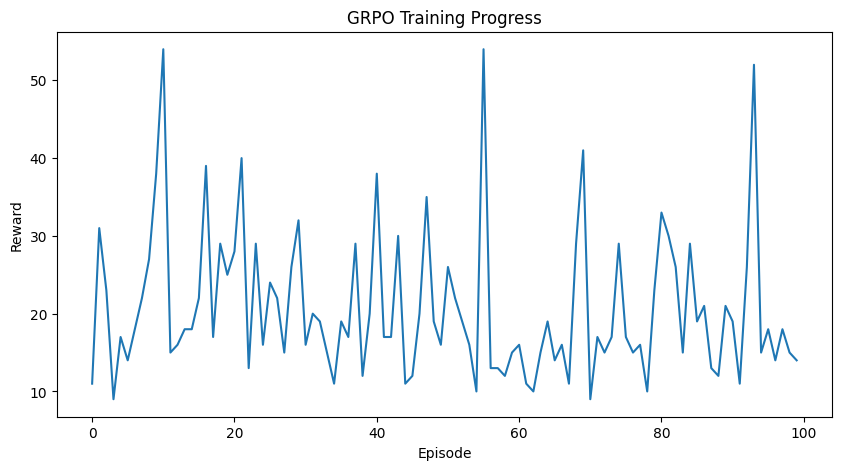

In [8]:
# 8. Exercise: Visualizing Training Progress

# Plot rewards over episodes to see how the agent is learning
plt.figure(figsize=(10, 5))
plt.plot(all_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('GRPO Training Progress')
plt.show()

# EXERCISE: What do you observe about the learning curve? Try running with different group sizes or learning rates and see how the plot changes!

# 9. Exercise: Hyperparameter Tuning

Try changing the following hyperparameters and observe their effect on GRPO performance:
- Learning rate (in the optimizer)
- Group size (number of responses per prompt)
- Hidden layer size in the policy network
- Number of training episodes

**Questions:**
- How does increasing the group size affect stability and learning speed?
- What happens if the learning rate is too high or too low?
- How does the policy network architecture impact performance?

*Modify the code above and re-run the training loop and plots to answer these questions!*

# Example: Solving the Same Task With RL (GRPO)

Now let's revisit the CartPole task, but this time using a policy learned with RL (GRPO).

- The RL agent starts with no knowledge and learns from experience.
- Over time, it discovers a much better policy than the hand-crafted rule.

*Compare the number of steps survived by the hand-crafted policy and the RL-trained policy. What do you observe?*

**This demonstrates the power of RL: the agent learns to outperform fixed rules by learning from experience!**

In [22]:
# Visualization for RL-Trained Policy (GRPO)
# Make sure to run the training loop first to train the policy network!
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def run_rl_policy(policy, render=True):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    state, info = env.reset()
    frames = []
    done = False
    steps = 0
    while not done:
        if render:
            frames.append(env.render())
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        logits = policy(state_tensor)
        action = torch.argmax(logits, dim=1).item()
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        steps += 1
    env.close()
    print(f'Pole fell after {steps} steps (RL-trained policy).')
    return frames

frames = run_rl_policy(policy)
display_frames_as_gif(frames)

Pole fell after 10 steps (RL-trained policy).


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
